In [356]:
import pandas as pd
import glob
import datetime
import os
import matplotlib.pyplot as plt
import itertools
import numpy as np
import seaborn as sns
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import normalize
import joblib
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(999)

## Draw pictures
1. ROC curves
2. feature importances
3. correlation matrix

In [357]:
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150
classifier_model = []
classifier_accuracy = []
CM = []
AUC = []
fpr_tpr = []
probability = []
def plot_roc_curve(fpr, tpr, auc, model):
    plt.plot(fpr, tpr, color='orange', label='ROC_' + model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUC: {:3f}'.format(auc))
    plt.legend()
    plt.axis([0, 1, 0, 1])
    plt.show()

def feature_importances(rfc,columns):
    rank = []
    importances = rfc.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfc.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(6,6))
    plt.title("Feature importances")

    for i in importances[indices][:]:
        index = np.where(importances ==i)
        rank.append(columns[index[0][0]])
    plt.bar(range(x_valid.shape[1]), importances[indices][:], align="center")
    plt.xticks(range(x_valid.shape[1]), rank, rotation=90,size=8)
    plt.xlim([-1, 20])
    plt.savefig(r'./feature.jpg')
    plt.show()

def correlation(x_valid):
    file = 'feature correlation'
    corr= x_valid.corr()
    fig = plt.figure(figsize=(10,10))
    sns.set(style="darkgrid")
    sns.heatmap(corr, cmap='RdBu', annot=True,fmt ='.2f',annot_kws={"size": 5}, vmin=0.5)
    # train_plt = sns.heatmap(corr_train, cmap='coolwarm', annot=False)
    plt.title(str(file))
    my_path = os.path.abspath('./Result')
    my_file = str(file) +'.png'
    plt.savefig(os.path.join(my_path, my_file)) 
    plt.show()

## Import data

In [370]:
with open('./Folder_name/XsmoteTrain.xlsx','rb') as t:
    x_train = pd.read_excel(t)
    x_columns = x_train.columns
with open('./Folder_name/YsmoteTrain.xlsx','rb') as t:
    y_train = pd.read_excel(t,squeeze=True)
with open('./Folder_name/XsmoteValid.xlsx', 'rb') as f:
    x_valid = pd.read_excel(f)
with open('./Folder_name/YsmoteValid.xlsx', 'rb') as f:
    y_valid = pd.read_excel(f,squeeze=True)

FileNotFoundError: [Errno 2] No such file or directory: './Folder_name/XsmoteTrain.xlsx'

## Data augmentation
- undersampling

In [357]:
# from imblearn.under_sampling import RandomUnderSampler 
# rus = RandomUnderSampler(random_state=42)
# x_train, y_train = rus.fit_resample(x_train, y_train)
# x_valid, y_valid = rus.fit_resample(x_valid, y_valid)

- oversampling

In [ ]:
# sm = SMOTE(sampling_strategy=0.6, random_state=999) # ratio={label:the number of label value}
# x_train, y_train = sm.fit_resample(x_train, y_train)

## Check no blank cell in dataframe

In [357]:
print(x_train.isnull().any())
print(x_train.columns[x_train.isnull().any()].tolist())

## Correlation matrix

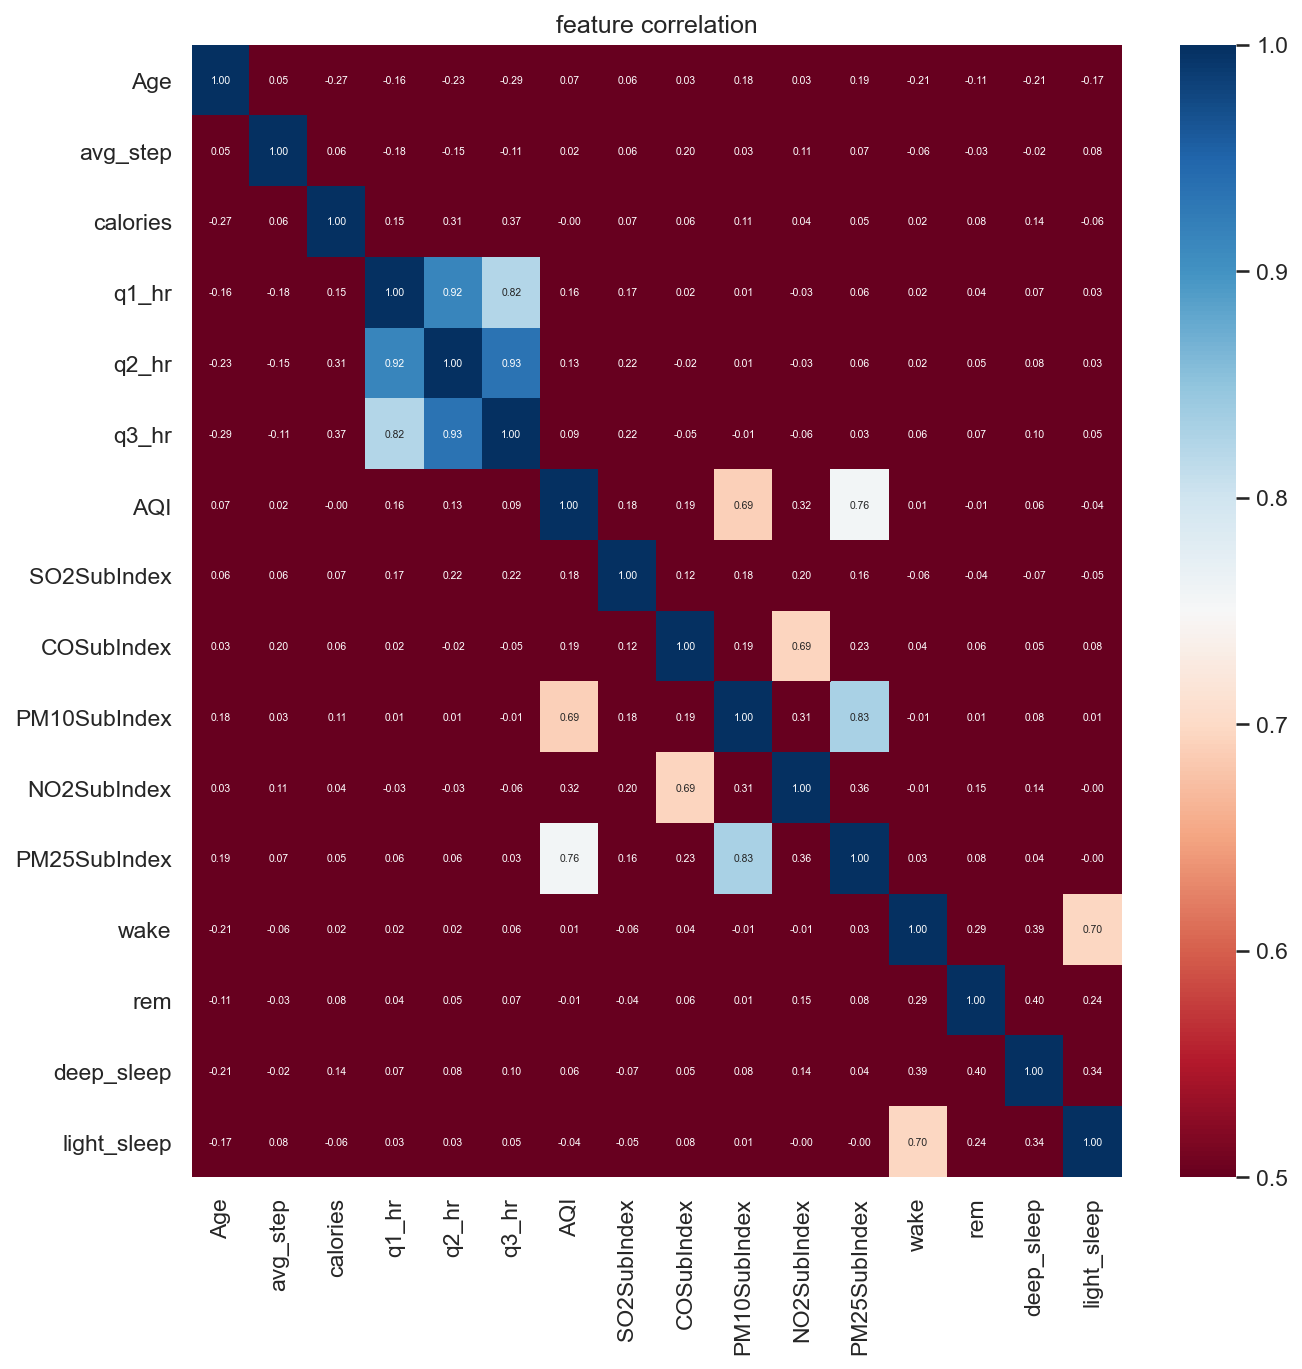

In [358]:
correlation(x_valid)

## Model
MLP classifier training

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
classifier_model.append('MLPClassifier')
clf = MLPClassifier(random_state=1,
                    max_iter=300,
                    hidden_layer_sizes=(64,32),
                    solver='adam',
                    learning_rate_init=0.00001,
                    learning_rate='adaptive',
                    batch_size=4,
                    activation='relu',
                    early_stopping=True,
                    verbose=True)

clf.fit(x_train, y_train)
joblib.dump(clf,'./model/MLPClassifier.pkl')
clf_cur= clf.loss_curve_
para = clf.get_params(deep=True)
print(para)

MLP classifier validating

In [ ]:
prob = clf.predict_proba(x_valid)[:,1]
y_pred = clf.predict(x_valid)
sco = clf.score(x_valid, y_valid)
auc = roc_auc_score(y_valid, prob)

classifier_accuracy.append(sco)
CM.append(confusion_matrix(y_valid, y_pred))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
# val_cur= clf.validation_scores_

MLP classifier learning curve

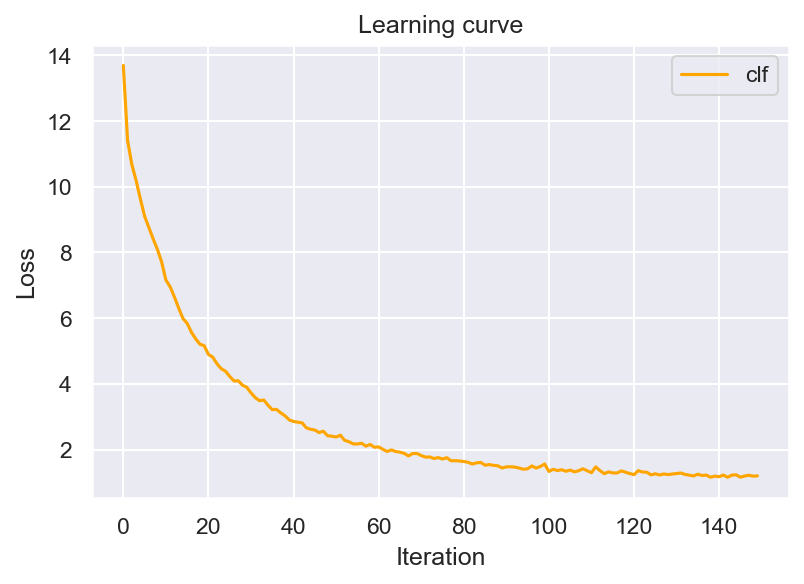

In [365]:
x1 = range(len(clf_cur))
plt.plot(x1,clf_cur, color='orange', label='clf')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend()
plt.savefig('Learning_curve.png')
plt.show()

Random forest training

In [363]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
classifier_model.append('RandomForest')
rfc = RandomForestClassifier(n_estimators = 300,
                             random_state =2,
                             min_samples_split = 4,
                             max_depth=30, 
                            oob_score=True,
                            class_weight={1:100, 0:5})
rfc.fit(x_train, y_train)
joblib.dump(rfc,'./model/RandomForest.pkl')

Random forest validating & feature importances

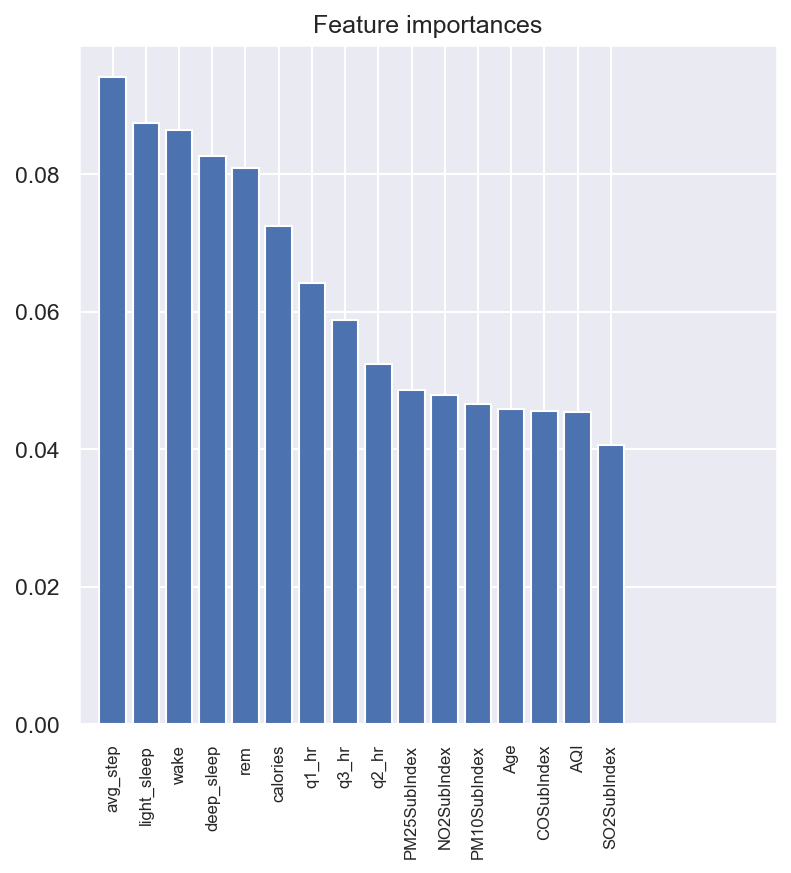

In [363]:
thre = 0.32
y_pred = rfc.predict(x_valid)
prob = rfc.predict_proba(x_valid)[:,1]
auc = roc_auc_score(y_valid, prob)
prec, rec, tre = precision_recall_curve(y_valid, prob)
pb = pd.DataFrame(rfc.predict_proba(x_valid),columns=['RF_false','RF_true'])
probability.append(pb)
classifier_accuracy.append(rfc.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
feature_importances(rfc,x_columns)
# plot_roc_curve(fpr, tpr, auc, 'RandomForest')

Decision Tree modeling

In [359]:
from sklearn.tree import DecisionTreeClassifier
classifier_model.append('DecisionTree')
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
joblib.dump(dtc,'./model/DecisionTree.pkl')
y_pred = dtc.predict(x_valid)
prob = dtc.predict_proba(x_valid)[:,1]
pb = pd.DataFrame(dtc.predict_proba(x_valid),columns=['DCT_false','DCT_true'])
auc = roc_auc_score(y_valid, prob)

probability.append(pb)
classifier_accuracy.append(dtc.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,y_pred))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_test, prob)
fpr_tpr += [[fpr, tpr]]
# plot_roc_curve(fpr, tpr, auc, 'DecisionTree')

Logistic Regression modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
thre = 0.3

classifier_model.append('LogisticRegression')
clf = LogisticRegression() 
clf.fit(x_train, y_train)
joblib.dump(clf,'./model/LogisticRegression.pkl')
y_pred = clf.predict(x_valid)
prob = clf.predict_proba(x_valid)[:,1]
prec, rec, tre = precision_recall_curve(y_valid, prob)
auc = roc_auc_score(y_valid, prob)

pb = pd.DataFrame(rfc.predict_proba(x_valid),columns=['CLF_false','CLF_true'])
probability.append(pb)

classifier_accuracy.append(clf.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
# plot_roc_curve(fpr, tpr, auc, 'RandomForest')

XGBoost modeling

In [ ]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
classifier_model.append('XgBoost')
xgb = XGBClassifier(objective="binary:logistic", learning_rate=0.00001, seed=1005)
# xgb = XGBClassifier(learning_rate=0.1,
#                     n_estimators=1000,         # 树的个数--1000棵树建立xgboost
#                     max_depth=6,               # 树的深度
#                     min_child_weight = 1,      # 叶子节点最小权重
#                     gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                     subsample=0.8,             # 随机选择80%样本建立决策树
#                     colsample_btree=0.8,       # 随机选择80%特征建立决策树
#                     objective='binary:hinge',  # 指定损失函数
#                     scale_pos_weight=3,        # 解决样本个数不平衡的问题
#                     random_state=27)
xgb.fit(x_train, y_train, early_stopping_rounds=15, eval_set=[(x_valid, y_valid)])
joblib.dump(xgb, './model/XgBoost.pkl')
y_pred = xgb.predict(x_valid)
prob = xgb.predict_proba(x_valid)[:,1]
auc = roc_auc_score(y_valid, prob)


classifier_accuracy.append(xgb.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid, y_pred))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
#plot_roc_curve(fpr, tpr, auc, 'XgBoost')

### plot feature importance
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(xgb,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()

Regularized Greedy Forest modeling & cross validate

In [ ]:
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from rgf.sklearn import RGFClassifier
classifier_model.append('RegularizedGreedyForest')
rgf = RGFClassifier(max_leaf=6500,
                    algorithm="RGF_Opt",
                    test_interval=100,
                    verbose=True,loss="Expo")

rgf.fit(x_train, y_train)
joblib.dump(rgf, './model/rgf.pkl')
y_pred = rgf.predict(x_valid)
prob = rgf.predict_proba(x_valid)[:, 1]
auc = roc_auc_score(y_valid, prob)

classifier_accuracy.append(rgf.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid, y_pred))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]


X = pd.concat([x_valid, x_train], axis=0, ignore_index=True)
y = pd.concat([y_valid, y_train], axis=0, ignore_index=True)
n_folds = 3
rgf_scores = cross_val_score(rgf,
                             X,
                             y,
                             cv=StratifiedKFold(n_folds))

rgf_score = sum(rgf_scores)/n_folds
print('RGF Classifier score: {0:.5f}'.format(rgf_score))

KNN modeling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
thre = 0.8
classifier_model.append('KNN')
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
joblib.dump(knn,'./model/knn.pkl')
y_pred = knn.predict(x_valid)
prob = knn.predict_proba(x_valid)[:,1]
pb = pd.DataFrame(knn.predict_proba(x_valid),columns=['KNN_false','KNN_true'])
auc = roc_auc_score(y_valid, prob)

probability.append(pb)
classifier_accuracy.append(knn.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
# plot_roc_curve(fpr, tpr, auc, 'knn')

LDA modeling

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
thre = 0.8
classifier_model.append('LDA')
lda = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage ='auto')
lda.fit(x_train, y_train)
y_pred = lda.predict(x_valid)
joblib.dump(lda,'./model/lda.pkl')
prob = lda.predict_proba(x_valid)[:,1]
pb = pd.DataFrame(lda.predict_proba(x_valid),columns=['LDA_false','LDA_true'])
auc = roc_auc_score(y_valid, prob)

probability.append(pb)
classifier_accuracy.append(lda.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
# plot_roc_curve(fpr, tpr, auc, 'lda')

AdaBoost modeling

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
thre = 0.8
classifier_model.append('AdaBoost')
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(x_train, y_train)
joblib.dump(AdaBoost,'./model/AdaBoost.pkl')
y_pred = AdaBoost.predict(x_valid)
prob = AdaBoost.predict_proba(x_valid)[:,1]
pb = pd.DataFrame(AdaBoost.predict_proba(x_valid),columns=['ADB_false','ADB_true'])
auc = roc_auc_score(y_valid, prob)

probability.append(pb)
classifier_accuracy.append(AdaBoost.score(x_valid, y_valid))
CM.append(confusion_matrix(y_valid,prob>thre))
AUC.append(auc)
fpr, tpr, thresholds = roc_curve(y_valid, prob)
fpr_tpr += [[fpr, tpr]]
# plot_roc_curve(fpr, tpr, auc, 'AdaBoost')

## Out of bag score

In [ ]:
from collections import OrderedDict
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_fe atures="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 300

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(x_valid, y_valid)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Cross validation

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(rfc, x_train, y_train, cv=3,
                         scoring=('r2', 'neg_mean_squared_error'),
                         return_train_score=True)
print(scores['test_neg_mean_squared_error'])
print(scores['train_r2'])

## Plot precision-recall curve

Average precision-recall score: 0.55


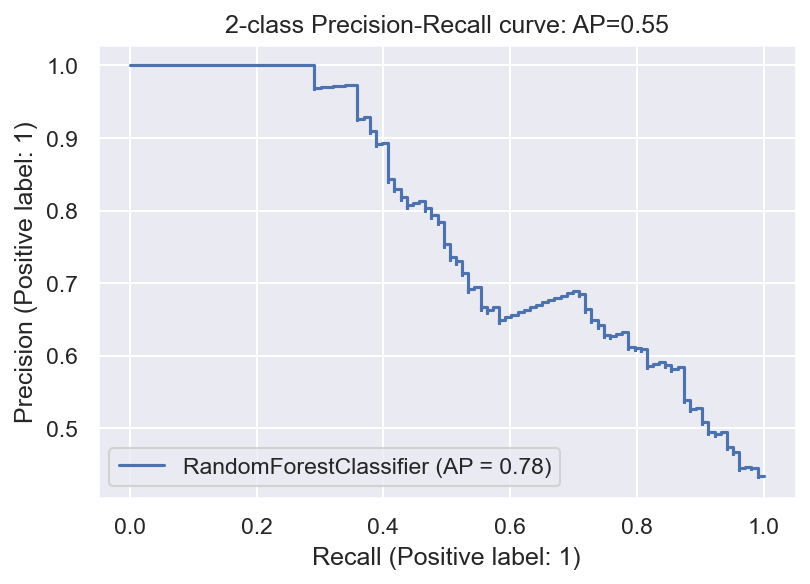

In [360]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_valid, prob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(rfc, x_valid, y_valid)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.savefig('PR_curve_0420.png')

## Plot precision and recall versus threshold

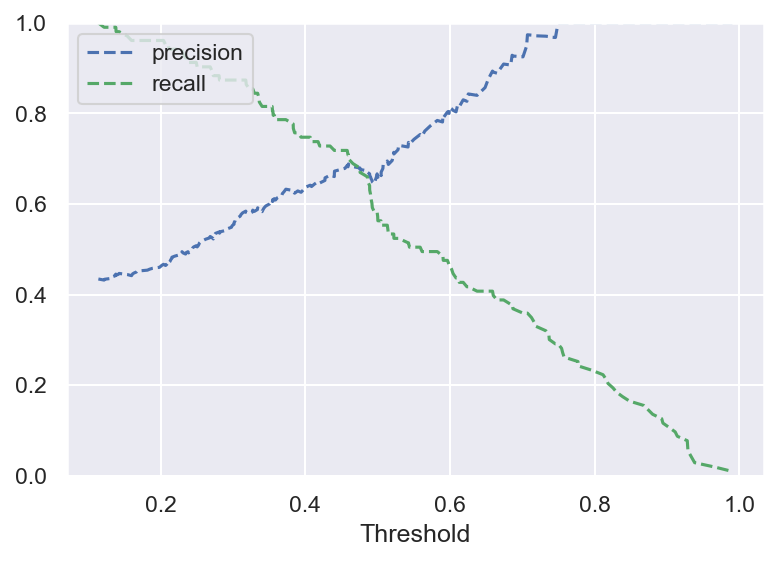

In [361]:
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

plot_prec_recall_vs_tresh(prec, rec, tre)
plt.savefig('PR_threshold.png')

## Plot AUROC Curve

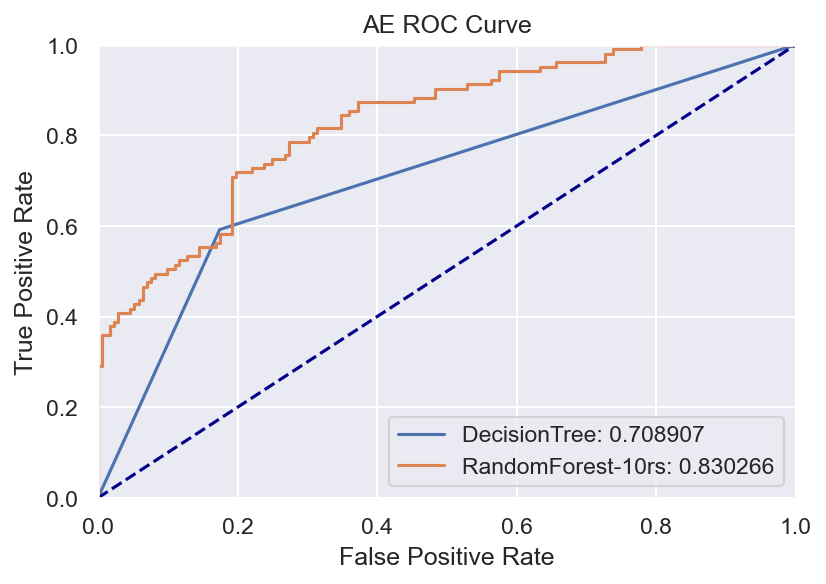

In [368]:
plt.figure()
for idx in range(len(fpr_tpr)):
    fpr, tpr = fpr_tpr[idx][0], fpr_tpr[idx][1]
    plt.plot(fpr, tpr, label=classifier_model[idx] + ': {0:4f}'.format(AUC[idx]))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AE ROC Curve')
plt.legend()
plt.axis([0, 1, 0, 1])
plt.savefig('AE.png')
# plt.show()

## Export result

In [369]:
# plot result table
result = {
    'model':classifier_model,
    'accuracy':classifier_accuracy,
    'confusion matrix':CM,
    'AUROC': AUC
}

result = pd.DataFrame(result).round(3)
print(result)
result['Specificity'] = result['confusion matrix'].apply(lambda x: x[0,0]/(x[0,0]+x[0,1])).round(3)
result['Sensitivity'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[1,0])).round(3)
result['Precision'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[0,1])).round(3)
result['F1_score'] = (2 / ((1/result['Sensitivity'])+(1/result['Precision']))).round(3)
result.to_excel('result.xlsx',index=False)
print(result)

# predict output
com = pd.DataFrame()
for idx in (probability):
    com = pd.concat([com,idx], axis = 1)
com.to_excel('prob_0115.xlsx',index=False)
predict = pd.concat([x_valid, y_valid], axis=1)
predict.to_excel('predict_0115.xlsx', index=False)

               model  accuracy       confusion matrix  AUROC
0       DecisionTree     0.738  [[142, 30], [42, 61]]  0.709
1  RandomForest-10rs     0.731  [[108, 64], [15, 88]]  0.830
               model  accuracy       confusion matrix  AUROC  Specificity  \
0       DecisionTree     0.738  [[142, 30], [42, 61]]  0.709        0.826   
1  RandomForest-10rs     0.731  [[108, 64], [15, 88]]  0.830        0.628   

   Sensitivity  Precision  F1_score  
0        0.592      0.670     0.629  
1        0.854      0.579     0.690  


NameError: name 'x_valid' is not defined

## Plot RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
X = pd.concat([x_valid, x_train], axis=0, ignore_index=True)
y = pd.concat([y_valid, y_train], axis=0, ignore_index=True)
rfecv = RFECV(estimator=rfc, step=1, cv=3,
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig('RFECV.png')
plt.show()

indices2 = np.argsort(rfecv.ranking_)[::-1]
for f in range(x_train.shape[1]):
    print("{}. {} {:4f}" .format(f + 1, x_train.columns[indices2[f]], rfecv.ranking_[indices2[f]]))

print(rfecv.ranking_)